# Reinforcement Learning aplicado al juego de Black Jack

El juego de Blackjack consiste en distribuir cartas entre un dealer y un participante. Los valores de las cartas J, Q y K tiene un valor igual a 10 y el As puede tomar el valor de 1 u 11, dependiendo del uso más beneficioso para cada jugador.

El juego será dividido en 4 partes:

1.  Inicio del juego: EL dealer reparte dos cartas para el participante y las coloca boca arriba de la mesa, luego toma dos cartas para su juego y coloca una carta boca arriba y otra boca abajo. Dando inicio al juego.
2. Juego del participante: Luego de iniciado el juego, el participante ve la suma actual de sus cartas, teniendo la opción de pedir una nueva carta con el objetivo de que la suma de sus cartas sea próximo a 21, pero sin llegar a pasar de esa cifra. Si al pedir una carta la suma pasa de 21, entonces se acaba el juego con derrota para el participante. Caso contrario, si el participante decide ya no pedir más cartas, entonces pasamos a la etapa del juego del diler.
3. Juego del dealer: Cuando el participante decide no pedir más cartas y la suma de sus cartas no es mayor que 21, entonces le toca jugar al diler. Se coloca su carta que estaba boca abajo visible para los jugadores. Si la suma es menor a 17, entonces el diler está obligado a tomar una carta hasta que la suma total sea mayor o igual a 17. Si la suma llega a pasar de 21, entonces inmediatamente el diler pierde el juego, logrando la victoria el participante. Caso contrario, su suma es mayor o igual a 17 y menor o igual a 21, entonces entramos en la etapa de comparación del juego.
4. Comparación final del juego: En esta etapa, comparamos la suma total de las cartas del diler y el participante, logrando la victoria quién tenga una suma mayor. Caso las sumas son iguales, entonces hay un empate en el juego.


Para resolver este problema, usaremos el método de montecarlo en forma secuencial, usando el método de iteración valor generalizado, y el método de Q-learning junto a la política $\varepsilon-$greedy.

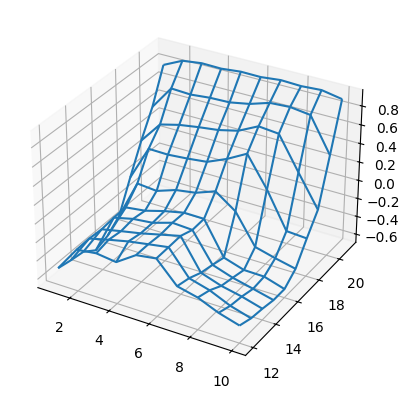

In [ ]:
import numpy as np
import random
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def carta():
  c = random.randint(1,14)
  if c > 10: c = 10
  return c

def suma(a, b, once):
  suma = a + b
  if once: # solo puede haber un once
    if suma > 21:
      suma = suma - 10
      once = False
  if not once:
    if a == 1 or b == 1:
      if suma <= 11:
        suma = suma + 10
        once = True
  return suma, once

def estado_ini():
  jug1,  jug2  = carta(), carta()
  suma_jug,  once_jug  = suma(jug1, jug2, False)
  while suma_jug < 12:  # se pide hasta sumar al menos 12
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug)
  casa = carta() # casa es la carta abierta de la casa, también elegida al azar
  return (suma_jug, casa, once_jug) # estado inicial S_0

def jugada(estado, accion):
  suma_jug, casa, once_jug = estado
  if accion == "hits": # accion hits
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug) # el jugador pide una carta
    if suma_jug > 21: # el jugador pierde por pasar de 21 (termina el juego)
      premio = -1
    else:
      premio = 0   # premio por pedir una carta
  elif accion == "sticks": # en este caso juega la casa y termina el juego
    suma_casa, once_casa = suma(casa, carta(), casa == 1) # suma carta no abierta de la casa
    while suma_casa < 17: # juega la casa
      suma_casa, once_casa = suma(suma_casa, carta(), once_casa)
    if suma_casa > 21:
      premio = 1 # la casa pierde por pasar de 21
    else:
      if suma_jug > suma_casa:   # jugador gana
        premio = 1
      elif suma_jug < suma_casa: # jugador pierde
        premio = -1
      else:                      # jugador empata
        premio = 0
  estado = (suma_jug, casa, once_jug) # estado siguiente
  return premio, estado

## inicializaciones
gamma, epsilon = 1, 0.1
estados_acciones_posibles = [((i,j,k),a) for i in range(12,22) for j in range(1,11) for k in [False, True] for a in ["hits", "sticks"]]
Politica = {id : 0.5 for id in estados_acciones_posibles} # política aleatoria
Q        = {id : 0   for id in estados_acciones_posibles}
N        = {id : 0   for id in estados_acciones_posibles}

for n in range(500000):
  ## inicio del juego
  historia = []
  estado = estado_ini() # estado inicial S_0
  while True:  # genera episodio = un juego
    accion = random.choices(["hits", "sticks"], weights = [Politica[estado, "hits"], Politica[estado, "sticks"]])[0]
    premio, estado_sgte = jugada(estado, accion)
    historia.append((estado, accion, premio))
    suma_jug, casa, once_jug = estado_sgte
    if suma_jug > 21 or accion == "sticks": break # termina el juego
    estado = estado_sgte # datos para siguiente iteracion

  G = 0
  while historia:
    estado, accion, premio = historia.pop()
    G = gamma * G + premio  # retorno
    if not (estado, accion) in [(est, acc) for est, acc, prm in historia]:
      N[estado, accion] += 1
      Q[estado, accion] = Q[estado, accion] + (G - Q[estado, accion]) / N[estado, accion]
      accion_max = "hits"
      if Q[estado, "hits"] < Q[estado, "sticks"]: accion_max = "sticks"
      Politica[(estado, "hits")] = Politica[(estado, "sticks")] = epsilon/2
      Politica[estado, accion_max] = 1 - epsilon + epsilon/2

X, Y = np.arange(12, 22), np.arange(1, 11)
Z = np.array([[max(Q[(i,j,False), "hits"], Q[(i,j,False), "sticks"]) for i in X] for j in Y])
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(Y, X, Z, rstride=1, cstride=1)
plt.show()

Usando Q-learning

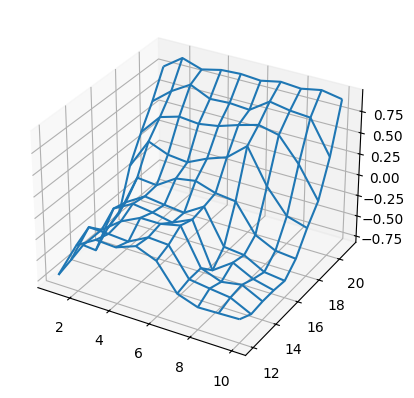

In [ ]:
import numpy as np
import random
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def carta():
  c = random.randint(1,14)
  if c > 10: c = 10
  return c

def suma(a, b, once):
  suma = a + b
  if once: # solo puede haber un once
    if suma > 21:
      suma = suma - 10
      once = False
  if not once:
    if a == 1 or b == 1:
      if suma <= 11:
        suma = suma + 10
        once = True
  return suma, once

def estado_ini():
  jug1,  jug2  = carta(), carta()
  suma_jug,  once_jug  = suma(jug1, jug2, False)
  while suma_jug < 12:  # se pide hasta sumar al menos 12
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug)
  casa = carta() # casa es la carta abierta de la casa, también elegida al azar
  return (suma_jug, casa, once_jug) # estado inicial S_0

def jugada(estado, accion):
  suma_jug, casa, once_jug = estado
  if accion == "hits": # accion hits
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug) # el jugador pide una carta
    if suma_jug > 21: # el jugador pierde por pasar de 21 (termina el juego)
      premio = -1
    else:
      premio = 0   # premio por pedir una carta
  elif accion == "sticks": # en este caso juega la casa y termina el juego
    suma_casa, once_casa = suma(casa, carta(), casa == 1) # suma carta no abierta de la casa
    while suma_casa < 17: # juega la casa
      suma_casa, once_casa = suma(suma_casa, carta(), once_casa)
    if suma_casa > 21:
      premio = 1 # la casa pierde por pasar de 21
    else:
      if suma_jug > suma_casa:   # jugador gana
        premio = 1
      elif suma_jug < suma_casa: # jugador pierde
        premio = -1
      else:                      # jugador empata
        premio = 0
  estado = (suma_jug, casa, once_jug) # estado siguiente
  return premio, estado

## inicializaciones
alpha, gamma, epsilon = 0.01, 1, 0.1
estados_acciones_posibles = [((i,j,k),a) for i in range(12,22) for j in range(1,11) for k in [False, True] for a in ["hits", "sticks"]]
Politica = {id : 0.5 for id in estados_acciones_posibles} # política aleatoria
Q        = {id : 0   for id in estados_acciones_posibles}

for n in range(500000):
  ## inicio del juego
  estado = estado_ini() # estado inicial S_0
  done = False
  while not done:
    accion = random.choices(["hits", "sticks"], weights = [Politica[estado, "hits"], Politica[estado, "sticks"]])[0]
    premio, estado_sgte = jugada(estado, accion)
    suma_jug, casa, once_jug = estado_sgte
    accion_max = "hits"
    if Q[estado, "hits"] < Q[estado, "sticks"]: accion_max = "sticks"
    if suma_jug > 21 or accion == "sticks":
      done = True
      Q[estado,accion] = Q[estado,accion] + alpha*(premio - Q[estado,accion])
    else:
      Q[estado,accion] = Q[estado,accion] + alpha*(premio + gamma*Q[(suma_jug, casa, once_jug),accion_max] - Q[estado,accion])
    Politica[(estado, "hits")] = Politica[(estado, "sticks")] = epsilon/2
    Politica[estado, accion_max] = 1 - epsilon + epsilon/2
    estado = (suma_jug, casa, once_jug)

X, Y = np.arange(12, 22), np.arange(1, 11)
Z = np.array([[max(Q[(i,j,False), "hits"], Q[(i,j,False), "sticks"]) for i in X] for j in Y])
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(Y, X, Z, rstride=1, cstride=1)
plt.show()

Otra forma de poder resolver el mismo problema.

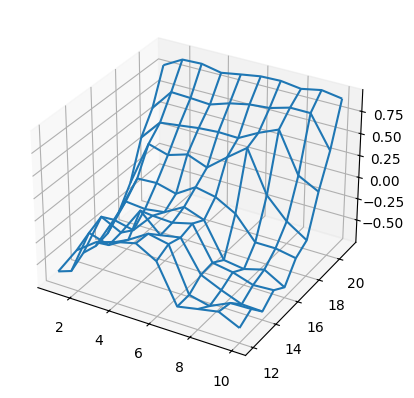

In [ ]:
import numpy as np
import random
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def epsilon_greedy(Q,estado): #Política épsilon-greedy
    accion_greedy = acciones[np.argmax([Q[estado,i] for i in acciones])]
    if np.random.rand() < epsilon:
        return random.choice(acciones), accion_greedy
    else:
        return accion_greedy, accion_greedy

def carta():
  c = random.randint(1,14)
  if c > 10: c = 10
  return c

def suma(a, b, once):
  suma = a + b
  if once: # solo puede haber un once
    if suma > 21:
      suma = suma - 10
      once = False
  if not once:
    if a == 1 or b == 1:
      if suma <= 11:
        suma = suma + 10
        once = True
  return suma, once

def estado_ini():
  jug1,  jug2  = carta(), carta()
  suma_jug,  once_jug  = suma(jug1, jug2, False)
  while suma_jug < 12:  # se pide hasta sumar al menos 12
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug)
  casa = carta() # casa es la carta abierta de la casa, también elegida al azar
  return (suma_jug, casa, once_jug) # estado inicial S_0

def jugada(estado, accion):
  suma_jug, casa, once_jug = estado
  if accion == "hits": # accion hits
    suma_jug, once_jug = suma(suma_jug, carta(), once_jug) # el jugador pide una carta
    if suma_jug > 21: # el jugador pierde por pasar de 21 (termina el juego)
      premio = -1
    else:
      premio = 0   # premio por pedir una carta
  elif accion == "sticks": # en este caso juega la casa y termina el juego
    suma_casa, once_casa = suma(casa, carta(), casa == 1) # suma carta no abierta de la casa
    while suma_casa < 17: # juega la casa
      suma_casa, once_casa = suma(suma_casa, carta(), once_casa)
    if suma_casa > 21:
      premio = 1 # la casa pierde por pasar de 21
    else:
      if suma_jug > suma_casa:   # jugador gana
        premio = 1
      elif suma_jug < suma_casa: # jugador pierde
        premio = -1
      else:                      # jugador empata
        premio = 0
  estado = (suma_jug, casa, once_jug) # estado siguiente
  return premio, estado

## inicializaciones
alpha, gamma, epsilon = 0.01, 1, 0.1
acciones = ["hits", "sticks"]
estados_acciones_posibles = [((i,j,k),a) for i in range(12,22) for j in range(1,11) for k in [False, True] for a in acciones]
Q        = {id : 0   for id in estados_acciones_posibles}

for n in range(500000):
  ## inicio del juego
  estado = estado_ini() # estado inicial S_0
  done = False
  while not done:
    accion, accion_greedy = epsilon_greedy(Q,estado)
    premio, estado_sgte = jugada(estado, accion)
    suma_jug, casa, once_jug = estado_sgte
    if suma_jug > 21 or accion == "sticks":
      done = True
      Q[estado,accion] = Q[estado,accion] + alpha*(premio - Q[estado,accion])
    else:
      Q[estado,accion] = Q[estado,accion] + alpha*(premio + gamma*Q[(suma_jug, casa, once_jug),accion_greedy] - Q[estado,accion])
    estado = (suma_jug, casa, once_jug)

X, Y = np.arange(12, 22), np.arange(1, 11)
Z = np.array([[max(Q[(i,j,False), "hits"], Q[(i,j,False), "sticks"]) for i in X] for j in Y])
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(Y, X, Z, rstride=1, cstride=1)
plt.show()